# Fitting experimental data: 1D mesh


**Attention:** use a kernel from a conda/mamba environment where fenicsx is installed

First some system libraries are loaded.

In [19]:
import sys
import math
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from copy import copy

Because the ADE_DG toolbox is (probably) not installed somewhere in the system we have to add the path to the location of the python code, either relative path or absolute path.
This notebook is in "Diffusion-Test-Models/DG-Diffusion-solver/docs/source/templates/" and we hav to add "Diffusion-Test-Models/DG-Diffusion-solver/sources/" to the path.


In [2]:
# import numerical toolbox ADE_DG for solving Advection-Diffusion-Equation specifically for trough-diffusion experiments
#import sys
sys.path.append("../../../sources") # include path to ../sources/ADE_DG1.py in path!

# ADE_DG1.py must be in the path -> see path settings above
import ADE_DG
from ADE_DG import BoundaryCondition as BoundaryCondition # import BoundaryCondition in this way, otherwise it is not available ...

## Load experimental data

This example uses Magick data, specifically experiment OPC26.

In principle one can load either text files or excel spreadsheets (requires openpyxl) with data. 
Best is to have data available in SI units, all other unit systems are not fail-save!
 * **times** in (s), relative to start of experiment
 * **volumetric concentrations**  (mol m⁻³) or (Bq m⁻³) or (kg m⁻³)
 * **fluxes** in (mol m⁻² s⁻¹) or (Bq m⁻² s⁻¹) or (kg m⁻² s⁻¹)
 * all other measurements in the same unit system!




In [3]:
# the next entry sets the precision for display of numbers
%precision %.2e

# load example dataset from Magick data
# define path to data directory
data_path="../../../../../Magick-Data/Through diffusion data _Magic_2025/OPC26/"
data_file_path="Experimental data_OPC26.ods"

# Load data sets from ods file ...sheet name needs to be known...excel files work in the same way
# we have the first two rows (0 and 1) for header, take first row for name (no.0) and skip second row (no.1)
Cusb=pd.read_excel(data_path+data_file_path,sheet_name='Cusb',header=0,skiprows=[1],engine='odf') # change the engine for excel files!
Jdsb=pd.read_excel(data_path+data_file_path,sheet_name='Jdsb',header=0,skiprows=[1])
Makk=pd.read_excel(data_path+data_file_path,sheet_name='Makk',header=0,skiprows=[1])

# next commands remove trailing whitespaces from columns names
# these are a constant source of trouble, 
#because they are not visible if you print them, but are assumed part of column names in python
Cusb.columns=Cusb.columns.str.strip()
Jdsb.columns=Jdsb.columns.str.strip()
Makk.columns=Makk.columns.str.strip()

# convert to correct units...in the dataset  the times are in Days! 
# (see skipped second row in excel spreadshee)
# 1Day = 1.0*24*3600
Day_to_sec=24.0*3600
Cusb.Time=Cusb.Time*Day_to_sec
Jdsb.Time=Jdsb.Time*Day_to_sec
Makk.Time=Makk.Time*Day_to_sec


To check the entries, we can print the datasets.

In [31]:
#print('{:.2e}'.format(Cusb.Cusb[0]))
display(Cusb,Jdsb,Makk)

,Time,Cusb,U(Cusb),Vhigh
0,0.000000e+00,0.000002,1.185347e-07,19.9634
1,3.443400e+05,0.000002,1.172375e-07,19.9136
2,8.768400e+05,0.000002,1.146135e-07,19.8633
3,1.554240e+06,0.000002,1.161075e-07,19.8128
4,2.156400e+06,0.000002,1.153999e-07,19.7642
5,2.778720e+06,0.000002,1.139443e-07,19.7138
6,3.368340e+06,0.000002,1.150209e-07,19.6634
7,3.978420e+06,0.000002,1.143098e-07,19.6132
8,4.418100e+06,0.000002,1.154624e-07,19.5627
9,5.197200e+06,0.000002,1.127417e-07,19.5116


,Time,JL,U(JL),Vlow
0,4.290000e+04,0.000000e+00,4.307374e-17,10.021
1,1.307400e+05,0.000000e+00,3.997594e-17,9.653
2,2.158800e+05,0.000000e+00,4.955385e-17,9.980
3,3.002100e+05,0.000000e+00,4.464265e-17,9.936
4,4.749300e+05,3.302417e-16,2.926315e-17,9.985
5,6.885300e+05,3.935459e-16,4.126927e-17,9.843
6,8.241900e+05,5.088438e-16,5.816691e-17,9.896
7,1.084740e+06,5.639572e-16,4.190633e-17,9.941
8,1.344150e+06,6.978680e-16,7.189790e-17,9.868
9,1.474950e+06,6.941983e-16,5.871355e-17,9.975


,Time,Accu,U(Accu),Zeit_s,Acum,u(Acum),Acum_m,U(Acum_m)
0,8.580000e+04,0.000000e+00,7.256543e-17,8.580000e+04,0.000000,0.077645,0.000000e+00,7.249768e-17
1,1.756800e+05,0.000000e+00,1.012073e-16,1.756800e+05,0.000000,0.108292,0.000000e+00,1.011128e-16
2,2.560800e+05,0.000000e+00,1.279163e-16,2.560800e+05,0.000000,0.136870,0.000000e+00,1.277968e-16
3,3.443400e+05,0.000000e+00,1.494921e-16,3.443400e+05,0.000000,0.159957,0.000000e+00,1.493525e-16
4,6.055200e+05,1.693564e-15,2.118221e-16,6.055200e+05,1.812114,0.226650,1.691983e-15,2.116243e-16
5,7.715400e+05,2.976443e-15,2.509317e-16,7.715400e+05,3.184794,0.268497,2.973664e-15,2.506974e-16
6,8.768400e+05,4.028509e-15,2.782626e-16,8.768400e+05,4.310504,0.297741,4.024747e-15,2.780028e-16
7,1.292640e+06,8.632776e-15,4.410040e-16,1.292640e+06,9.237070,0.471874,8.624715e-15,4.405923e-16
8,1.395660e+06,1.004442e-14,4.643660e-16,1.395660e+06,10.747527,0.496872,1.003504e-14,4.639324e-16
9,1.554240e+06,1.220595e-14,4.990570e-16,1.554240e+06,13.060368,0.533991,1.219455e-14,4.985910e-16


In the next cell we have to insert some values for the diffusion cell:

The values are used (partly) for calculations, therefore units need to follwo SI..
Here I made a screenshot from spreadsheet for OPC26
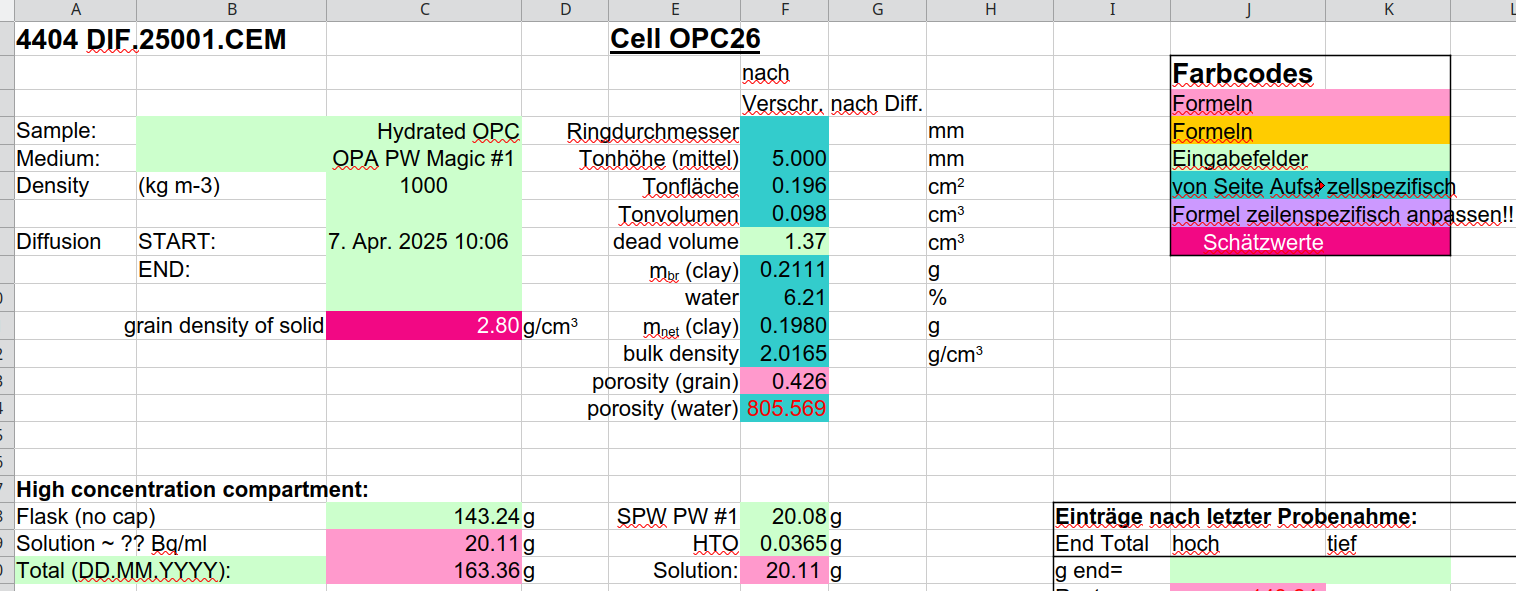
and here the right side with some uncertainties for measurements
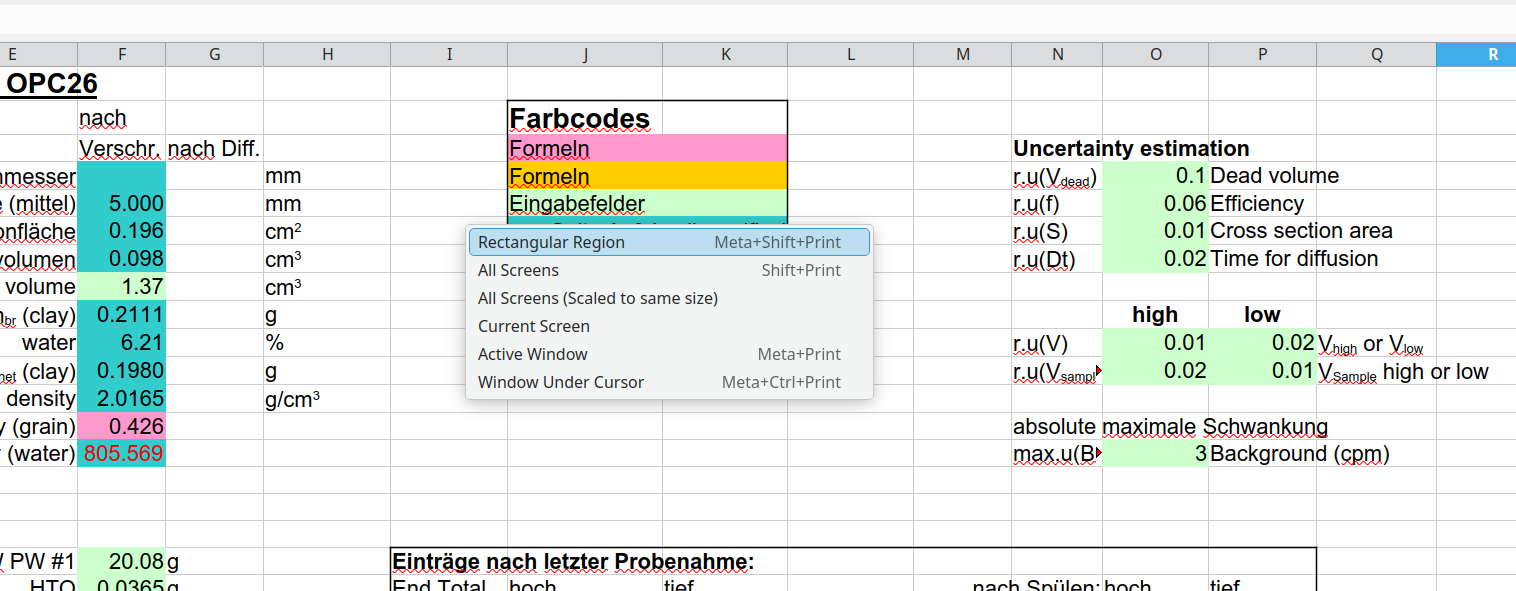

Experiment was conducted at 40°C
Temperature influence on reservoir volumes was not considered for estimation of experimental results..
Dead volume (missing filters) was not considered for reservoir volumes!



In the next cell we set some of these values. Please note, that volumes and concentrations are taken from experimental datasets.

To simplify access to experimenal data for fitting, we create to data vectors:
* tdat: time in seconds
* fdat: downstream fluxes in mol/m³/s

In [5]:
#sample thickness
sample_thickness=5e-3 # unit (m) = 5 mm
cross_section_area = 0.196e-4 # unit (m²) 0.196 cm * cm
# first attempt: we start with constant reservoir volumes
upstream_volume=Cusb.Vhigh[0]
downstream_volume=Jdsb.Vlow[0]
upstream_concentration=Cusb['Cusb'][0]
downstream_concentration=0.0


# select fitting parameter for breakthrough
tdat=Jdsb.Time[0:]
fdat=Jdsb.JL[0:]



## Create and initialize function for numerical solver

One has to initialize and create a function that can be called from the fitting routine. 

The basic setup is based on mesh that was created with gmsh:

    * The dimensions of the mesh should be choosen that they represent the dimensions of the diffusion cell, filters, sample.
    * The different materials (sample, filter) and the influx (upstream) and outflux (downstream) boundaries have to be marked with "physical group Ids"
    * It is assumed the the upstream boundary is at x=0m and the downstream boundary at x = "lenght of sample + filters" in positive x-direction

The numerical solver is initialized via the ADE_DG call that reads the mesh from a file and requires a parameter that sets the "degree" of DG elements.

For the numerical setup the follwing parameters have to be defined and passed to the code:

    * material parameters
        - De and porosity/alpha for all materials (filter,sample)
        - Cross sectional area of the sample/filters
    * initial conditions
       - Initial concentrations everywhere in the domain
    * boundary conditions
        - Position of the boundaries and their physical group id (marker no.)
        - Initial concentrations in the Upstream and Downstream reservoirs
        - Volume of the reservoirs
        - A flag that sets constant (boundary) concentrations in the reservoir: set_update_reservoir_boundaries(False), 
          or adjusts reservoir concentrations according to fluxes out of or into the reservoir: set_update_reservoir_boundaries(True)
         - A list with times at which downstream reservoir concentrations are measured and downstream solutions were changed. 
         These timess are used for controlling the time steps such that numerical solutions are calculated exactly at these times. 
         If set_update_reservoir_boundaries(True) is set, downstream concentrations are set to zero after these times. 
        


We need to know how boundaries and regions are marked in the mesh file. 
One possibility is to look into the gmsh geo file:

    // Gmsh project created on Tue Jul 22 14:36:22 2025
    //+
    Point(1) = {0.0, 0.0, 0, 0.0003};
    //+
    Point(2) = {0.005, 0.0, 0, 0.0003};
    //+
    Point(3) = {0, 0.00025, 0, 0.0003};
    //+
    Point(4) = {0.005, 0.00025, 0, 0.0003};
    //+
    Line(1) = {3, 1};
    //+
    Line(2) = {2, 1};
    //+
    Line(3) = {2, 4};
    //+
    Line(4) = {4, 3};
    //+
    Curve Loop(1) = {1, -2, 3, 4};
    //+
    Plane Surface(1) = {1};
    //+
    Physical Curve("upstream_boundary", 5) = {1};
    //+
    Physical Curve("downstream_boundary", 6) = {3};
    //+
    Physical Surface("sample", 7) = {1};


As one can see, upstream_boundary and downstream_boundaray are marked with ids 5 and 6, and the sample is id = 7.

In [11]:
# boundary and sample ids

upstream_id=5
downstream_id=6
sample_id=7
# boundary x-coordinate
upstream_x=0.0 # x coordinate of boundary
downstream_x=0.005

sample_id=7

In [32]:
# general definitions    
hour=3600.0
day=hour*24.0
year=day*365.25



# define everything once

# initial conditions
C0=0.0 # initial condition

# effective Diffusion for all marked materials in terms of an dictionary
# we introduce default values
# markers can be found in gmsh geo file
De=1.0e-11
De_dict={
    sample_id : 1.0e-11,   #sample
}

# porosity/alpha ..this are default values in form of an dictionary
alpha=0.1
porosity_dict={
    sample_id : alpha    #sample
}
# if diffusion only the Darcy flux is 0.0 (zero) for all components
darcy_flux_vector = (0.0,0.0) # list  will work for 1D and 2D meshes that have two coordinates for points (x,y) ...3D meshes need 3 entries

Now one can define the numerical solver by first defining the path to the mesh-file and then creating the "problem"
object.


In [33]:
# filename for gmsh file
mymesh_filename = "../../../notebooks/gmsh/Magick.msh"
# define problem
# degree of desired FE is moved into ADE_DG
problem = ADE_DG.ADE_DG(mymesh_filename,deg=2)

INFO:root:INFO: init with: ../../../notebooks/gmsh/Magick.msh deg 2
INFO:root:INFO: mesh read! mesh dimension: 2 boundary dimension 1 geometry dimension: 2


Info    : Reading '../../../notebooks/gmsh/Magick.msh'...
Info    : 9 entities
Info    : 36 nodes
Info    : 36 elements
Info    : Done reading '../../../notebooks/gmsh/Magick.msh'


In [34]:
problem.set_initial_conditions(C0)

problem.set_darcy_flux(darcy_flux_vector)
problem.set_De(De_dict) # argumant is a dictionary
problem.set_porosity(porosity_dict) # argument is a dictionary
problem.set_upstream_boundary(upstream_id,upstream_x) # should be "left boundary"
problem.set_upstream_reservoir_concentration(upstream_concentration) 
problem.set_upstream_reservoir_volume(upstream_volume)
problem.set_downstream_boundary(downstream_id,downstream_x) # should be "right  boundary"
problem.set_downstream_reservoir_concentration(0.0) 
problem.set_downstream_reservoir_volume(downstream_volume)
problem.set_downstream_reservoir_exchange_solution_times(tdat) # needs to be done, even if update_reservoir_boundaries(False) is set!
problem.set_update_reservoir_boundaries(False) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties
problem.set_cross_section_area(cross_section_area) # 1 for comparison with analytical solution


INFO:root:Darcy flux is set to: (0.0, 0.0) for the whole domain.
INFO:root:INFO: De set via dictionary {7: 1e-11} default: 1.0e-11 
INFO:root:porosity set via dictionary {7: 0.1} default: 1.0


The next cell contains a function that actually solves the diffusion equation based on boundary conditions, initial conditions and for a given set of alpha(=porosity) and De values.
The function returns a vector with downstream fluxes for times defined in tdat (the experimental values).



In [35]:
def flux_model(t,alpha,De):
    # t is log space -> set to real space
    t_real= t #np.pow(t,10.0)

    normalization_factor=upstream_concentration
    #### definitions for ADE-DG solutions that need to be re-set for multiple runs
    # only reset everything that is changed during simulations or due to call -> alpha   
    
    # porosity
    porosity_dict={
        7 : alpha  #sample
    }
    De_dict={
        7 : De,   #sample
    }
    u_old=problem.set_initial_conditions(C0/normalization_factor)
    u_new=copy(u_old) # make a copy for u_new

    problem.set_porosity(porosity_dict)
    problem.set_De(De_dict)

    #problem.set_upstream_boundary(5,0.0) # should be "left boundary"
    problem.set_upstream_reservoir_concentration(upstream_concentration/normalization_factor)
    
    #problem.set_downstream_boundary(6,0.005) # should be "right  boundary"
    problem.set_downstream_reservoir_concentration(0.0/normalization_factor)
    
    problem.set_update_reservoir_boundaries(False) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties
    
    # Time stepping
    t_end=max(t)
    dt=1000.0 # for adaptive time stepping this is not important
    problem.set_dt(dt)
    problem.set_T_end(t_end)
    problem.set_tol_adaptive(1.0e-3) # this should work fine if normalisation is applied
    
    solution,data=problem.solve_adaptive_timesteps()
    # inverse normalisation
    solution.x.array[:]=solution.x.array[:]*normalization_factor
    data.iloc[:,2:]=data.iloc[:,2:]* normalization_factor
    
    # for time interpolation we can use np.interpolate
    flux=np.interp(t_real, data.time, np.abs(data.Downstream_flux)) 
    #print("Debug flux_model: called with alpha,De",alpha,De)
    #print("Debug: solution, data, flux ",solution,data,flux)
    return (flux) 

## One manual run to test parameters

Before one does possibly time consuming fitting, it makes sense to once run the model to check input parameters and if the model runs at all.

One manual run takes about 1.4 seconds on my linux workstation.

In [36]:
myflux=flux_model(tdat,0.6,2.5e-12)

INFO:root:porosity set via dictionary {7: 0.6} default: 1.0
INFO:root:INFO: De set via dictionary {7: 2.5e-12} default: 1.0e-11 
INFO:root:INFO: Adaptive time loop starts with error tolerance: 0.001 update_reservoir_concentrations: False
INFO:root:INFO: t dt error est     0.0000 |  1000.0000 |  1.070e-05
INFO:root:INFO: t dt error est  1000.0000 |  9169.1962 |  1.797e-05
INFO:root:INFO: t dt error est 10169.1962 | 42900.0000 |  1.262e-05
INFO:root:INFO: t dt error est 53069.1962 | 42900.0000 |  4.971e-06
INFO:root:INFO: t dt error est 95969.1962 | 42900.0000 |  4.147e-06
INFO:root:INFO: t dt error est 138869.1962 | 42900.0000 |  3.639e-06
INFO:root:INFO: t dt error est 181769.1962 | 42900.0000 |  3.285e-06
INFO:root:INFO: t dt error est 224669.1962 | 42900.0000 |  3.028e-06
INFO:root:INFO: t dt error est 267569.1962 | 42900.0000 |  2.836e-06
INFO:root:INFO: t dt error est 310469.1962 | 42900.0000 |  2.685e-06
INFO:root:INFO: t dt error est 353369.1962 | 42900.0000 |  2.563e-06
INFO:roo

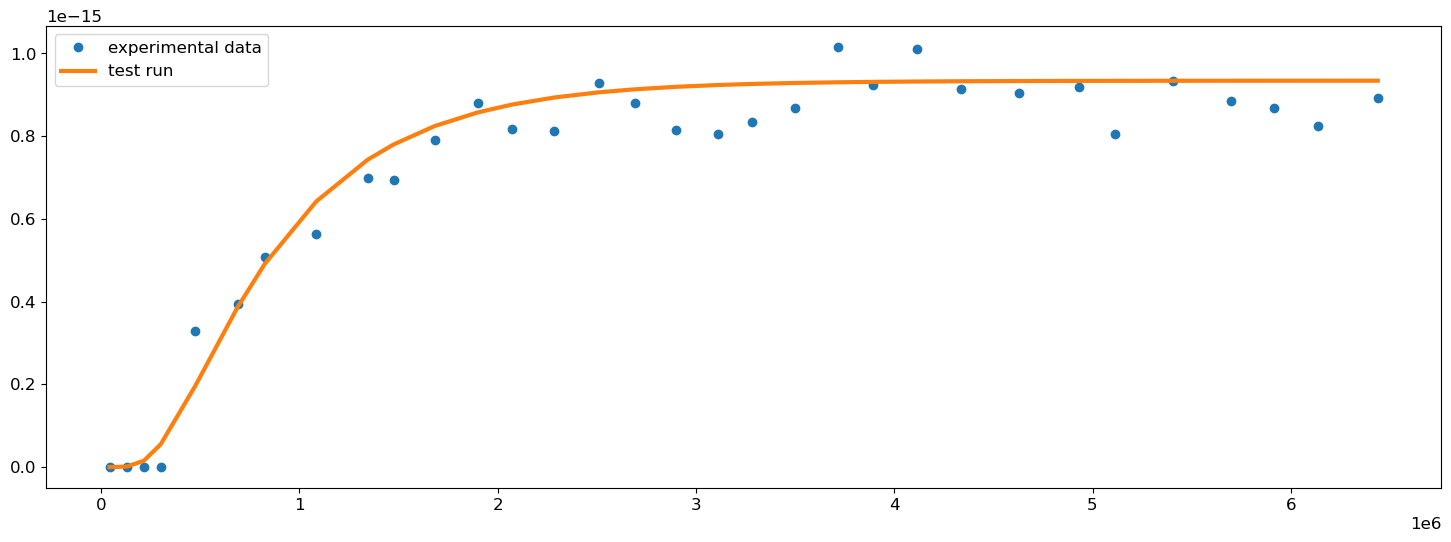

In [37]:
# we plot the fluxes ...aka breakthrough

plt.rcParams["figure.figsize"] = [18, 6]

plt.rcParams.update({'lines.linewidth':3}) # plt parameters are used also for next plots! -> change again if necessary
#display(fluxes)

plt.rcParams.update({'font.size': 12}) # update font size..default is 10 !

plt.plot(tdat, fdat, 'o',label='experimental data')

plt.plot(tdat, myflux, '-', label='test run')

plt.legend()
plt.show()

## Fitting with LMFIT

https://lmfit.github.io/lmfit-py/intro.html

The lmfit package provides simple tools to help you build complex fitting models for non-linear least-squares problems and apply these models to real data.

**Install lmfit-py with** **"mamba install lmfit"**

Why use lmfit?

While scipy offers an standard approach to optimization and curve fitting, LMFIT is a specialised tool that offers better support for advanced methods and diagnostic tools!


In [38]:

import lmfit as lmfit

#params = lmfit.Parameters()
#params.add('alpha', 0.6) # starting value for fit
#params.add('De', value=3.0e-12) # starting value for fit


The next cell sets up the fitting with the lmfit package:

The fitting takes about 27 seconds on my linux workstation.

In [39]:
problem.set_logging_level("ERROR") # This gives only information in case of errors 

ademodel=lmfit.Model(flux_model)
print(f'parameter names: {ademodel.param_names}')
print(f'independent variables: {ademodel.independent_vars}')

result_ademodel=ademodel.fit(fdat, t=tdat, alpha=0.3,De=3.0e-12)


print(result_ademodel.fit_report())


set logging to level:  ERROR
parameter names: ['alpha', 'De']
independent variables: ['t']
[[Model]]
    Model(flux_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 32
    # variables        = 2
    chi-square         = 9.9357e-32
    reduced chi-square = 3.3119e-33
    Akaike info crit   = -2391.27441
    Bayesian info crit = -2388.34294
    R-squared          = 1.00000000
[[Variables]]
    alpha:  0.55177148 +/- 0.03206107 (5.81%) (init = 0.3)
    De:     2.3807e-12 +/- 3.5337e-14 (1.48%) (init = 3e-12)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, De) = +0.6393


For simple evaluation of uncertainty bands the following command is suggested.
This takes about 10 seconds on my linux workstation.

In [40]:
dely = result_ademodel.eval_uncertainty(sigma=3)

#plt.fill_between(x, result.best_fit-dely, result.best_fit+dely, color="#ABABAB",
#                 label=r'3-$\sigma$ uncertainty band')

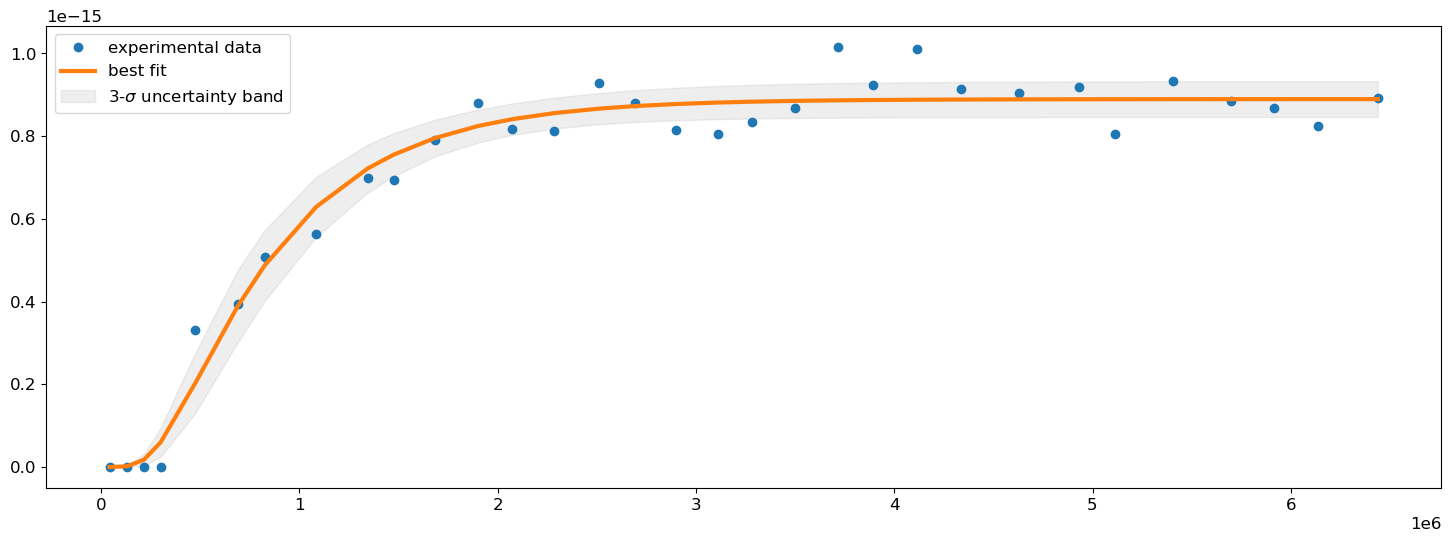

In [41]:
# we plot the fluxes ...aka breakthrough
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [18, 6]

plt.rcParams.update({'lines.linewidth':3}) # plt parameters are used also for next plots! -> change again if necessary
#display(fluxes)

plt.rcParams.update({'font.size': 12}) # update font size..default is 10 !

plt.plot(tdat, fdat, 'o',label='experimental data')
#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')
plt.plot(tdat, result_ademodel.best_fit, '-', label='best fit')
plt.fill_between(tdat, result_ademodel.best_fit-dely, result_ademodel.best_fit+dely, color="#ABABAB",
                 label=r'3-$\sigma$ uncertainty band',alpha=0.2)

plt.legend()
plt.show()